In [25]:
# from openairclim.calc_ch4 import calc_swv_mass_conc
from openairclim.calc_swv import get_alpha_AOA, get_volume_matrix
import numpy as np
import matplotlib.pyplot as plt
from ambiance import Atmosphere
import pandas as pd
import random
M_h2o = 18.01528 * 10**-3  # kg/mol
M_air = 28.97 * 10**-3  # kg/mol


In [26]:
# m, c,d = calc_swv_mass_conc([1,1,1,1,1,1])

In [27]:
def calc_swv_mass_conc(delta_ch4, alpha_new = None, aoa_new=None, factor_new=None):
    """
    Calculates the SWV concentration and mass based on the oxidation of CH4. It is based on the tropospheric CH4 change, the fractional release factor, and the Age-of-Air.
    Based on the papers of Austin 2007, Hegglin 2014 and Harmsen 2026 #TODO make the citations correct

    Args:
        delta_ch4 (list): List of yearly changes in CH4 concentration due to an emission.
        alpha (np.ndarray): The fractional release factor of CH4, based on altitude and latitude.
        AoA: (np.ndarray): The age-of-air based on altitude and latitude rounded to the nearest integer year.

    Returns:
        delta_mass_swv (list): A list of the total change in SWV mass in Tg due to CH4 oxidation for each year corresponding to delta_ch4.
        delta_conc_swv (list): A list with the average stratospheric concentration change of SWV in ppbv due to CH4 oxidation for each year corresponding to delta_ch4.
    """
    # initialize
    delta_mass_swv = np.ones(len(delta_ch4))
    delta_conc_swv = np.ones(len(delta_ch4))

    # define constants
    delta_h = 100.0  # height increment in meters
    delta_deg = 1.0  # latitude increment
    heights = np.arange(0, 60000 + delta_h, delta_h)  # 0 to 60 km

    latitudes = np.arange(
        -85, 85, delta_deg
    )  # -85° to 85° #TODO verify these numbers, justify the values,
    # TODO this gives sometimes a non 0 in the first year, why?
    # TODO probably due to the extrpolating of the grid introducing tropospheric values

    volume = get_volume_matrix(heights, latitudes, delta_h, delta_deg)
    density = Atmosphere(heights).density
    mass_mat = volume * density[:, np.newaxis]  # kg
    alpha, AoA = get_alpha_AOA(heights, latitudes, plot_data=False)
    if alpha_new != None:
        alpha = alpha_new*alpha
    if aoa_new != None:
        aoa = pd.DataFrame(0.3 + 15.2 * alpha - 21.2 * alpha**2 + 10.4 * alpha**3)
        AoA = (aoa * aoa_new).round(0)
        
    for t in range(len(delta_ch4)):
        # get swv distribution
        multiplier_map = {
            1: delta_ch4[t - 1] if t - 1 >= 0 else 0.0,
            2: delta_ch4[t - 2] if t - 2 >= 0 else 0.0,
            3: delta_ch4[t - 3] if t - 3 >= 0 else 0.0,
            4: delta_ch4[t - 4] if t - 4 >= 0 else 0.0,
            5: delta_ch4[t - 5] if t - 5 >= 0 else 0.0,
        }
        df_ch4_lagged = AoA.replace(multiplier_map)
        if factor_new == None:
            swv = 2 * alpha * df_ch4_lagged  # ppbv
        else:
            swv = factor_new *alpha * df_ch4_lagged

        # calculate average concentration
        number_density = Atmosphere(heights).number_density
        swv_parts_mat = volume * number_density[:, np.newaxis] * swv * 1e-9
        tot_parts = np.nansum(
            (
                volume
                * np.where(np.isnan(swv_parts_mat), np.nan, 1)
                * number_density[:, np.newaxis]
            )
        )  # to make sure only stratospheric volume is taken
        average_conc = np.nansum(swv_parts_mat) / tot_parts * 1e9  # ppbv

        # calculate total swv mass
        SWV_mass_mat = swv * 10**-9 * M_h2o / M_air * mass_mat  # kg
        swv_mass = np.nansum(SWV_mass_mat) / 1e9  # Tg
        # print(swv_mass)

        # store data
        delta_mass_swv[t] = swv_mass  # Tg
        delta_conc_swv[t] = average_conc  # ppbv
    final_swv_distribution = swv
    return delta_mass_swv, delta_conc_swv, final_swv_distribution

In [28]:
def calc_swv_mass_conc_absolute(delta_ch4, alpha_new = None, aoa_new=None, factor_new=None):
    """
    Calculates the SWV concentration and mass based on the oxidation of CH4. It is based on the tropospheric CH4 change, the fractional release factor, and the Age-of-Air.
    Based on the papers of Austin 2007, Hegglin 2014 and Harmsen 2026 #TODO make the citations correct

    Args:
        delta_ch4 (list): List of yearly changes in CH4 concentration due to an emission.
        alpha (np.ndarray): The fractional release factor of CH4, based on altitude and latitude.
        AoA: (np.ndarray): The age-of-air based on altitude and latitude rounded to the nearest integer year.

    Returns:
        delta_mass_swv (list): A list of the total change in SWV mass in Tg due to CH4 oxidation for each year corresponding to delta_ch4.
        delta_conc_swv (list): A list with the average stratospheric concentration change of SWV in ppbv due to CH4 oxidation for each year corresponding to delta_ch4.
    """
    # initialize
    delta_mass_swv = np.ones(len(delta_ch4))
    delta_conc_swv = np.ones(len(delta_ch4))

    # define constants
    delta_h = 100.0  # height increment in meters
    delta_deg = 1.0  # latitude increment
    heights = np.arange(0, 60000 + delta_h, delta_h)  # 0 to 60 km

    latitudes = np.arange(
        -85, 85, delta_deg
    )  # -85° to 85° #TODO verify these numbers, justify the values,
    # TODO this gives sometimes a non 0 in the first year, why?
    # TODO probably due to the extrpolating of the grid introducing tropospheric values

    volume = get_volume_matrix(heights, latitudes, delta_h, delta_deg)
    density = Atmosphere(heights).density
    mass_mat = volume * density[:, np.newaxis]  # kg
    alpha, AoA = get_alpha_AOA(heights, latitudes, plot_data=False)
    alpha = pd.DataFrame(alpha)
    if alpha_new != None:
        alpha = (alpha + alpha_new).clip(lower=0, upper=1)
    if aoa_new != None:
        aoa = pd.DataFrame(0.3 + 15.2 * alpha - 21.2 * alpha**2 + 10.4 * alpha**3)
        AoA = (aoa + aoa_new).clip(lower=0).round(0)
        
    for t in range(len(delta_ch4)):
        # get swv distribution
        multiplier_map = {
            1: delta_ch4[t - 1] if t - 1 >= 0 else 0.0,
            2: delta_ch4[t - 2] if t - 2 >= 0 else 0.0,
            3: delta_ch4[t - 3] if t - 3 >= 0 else 0.0,
            4: delta_ch4[t - 4] if t - 4 >= 0 else 0.0,
            5: delta_ch4[t - 5] if t - 5 >= 0 else 0.0,
        }
        df_ch4_lagged = AoA.replace(multiplier_map)
        if factor_new == None:
            swv = 2 * alpha * df_ch4_lagged  # ppbv
        else:
            swv = (2+factor_new) *alpha * df_ch4_lagged

        # calculate average concentration
        number_density = Atmosphere(heights).number_density
        swv_parts_mat = volume * number_density[:, np.newaxis] * swv * 1e-9
        tot_parts = np.nansum(
            (
                volume
                * np.where(np.isnan(swv_parts_mat), np.nan, 1)
                * number_density[:, np.newaxis]
            )
        )  # to make sure only stratospheric volume is taken
        average_conc = np.nansum(swv_parts_mat) / tot_parts * 1e9  # ppbv

        # calculate total swv mass
        SWV_mass_mat = swv * 10**-9 * M_h2o / M_air * mass_mat  # kg
        swv_mass = np.nansum(SWV_mass_mat) / 1e9  # Tg
        # print(swv_mass)

        # store data
        delta_mass_swv[t] = swv_mass  # Tg
        delta_conc_swv[t] = average_conc  # ppbv
    final_swv_distribution = swv
    return delta_mass_swv, delta_conc_swv, final_swv_distribution

In [29]:
m, c, d = calc_swv_mass_conc([1,1,1,1,1,1,1,1,1])

In [30]:
alpha_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
aoa_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
factor_dict = {'input':[1.8, 1.9, 2, 2.1, 2.2], 'output':[]}
for alpha_new in alpha_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], alpha_new=alpha_new)
    print('alpha:', alpha_new, 'mass:', m[-1])
    alpha_dict['output'].append(m.round(5))
for aoa_new in aoa_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], aoa_new=aoa_new)
    print('aoa:', aoa_new, 'mass:', m[-1])
    aoa_dict['output'].append(m.round(5))
for factor_new in factor_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], factor_new=factor_new)
    print('factor:', factor_new, 'mass:', m[-1])
    factor_dict['output'].append(m.round(5))
alpha_dict

alpha: 0.9 mass: 20.965149587098267
alpha: 0.95 mass: 22.129880119714834
alpha: 1 mass: 23.29461065233141
alpha: 1.05 mass: 24.459341184947974
alpha: 1.1 mass: 25.624071717564547
aoa: 0.9 mass: 23.25960819931435
aoa: 0.95 mass: 23.28060461225799
aoa: 1 mass: 23.29461065233141
aoa: 1.05 mass: 23.30637046677214
aoa: 1.1 mass: 23.315187484545557
factor: 1.8 mass: 20.965149587098267
factor: 1.9 mass: 22.129880119714834
factor: 2 mass: 23.29461065233141
factor: 2.1 mass: 24.459341184947974
factor: 2.2 mass: 25.624071717564547


{'input': [0.9, 0.95, 1, 1.05, 1.1],
 'output': [array([ 0.     ,  1.63641,  6.1147 , 12.87088, 20.96515, 20.96515,
         20.96515]),
  array([ 0.     ,  1.72732,  6.45441, 13.58592, 22.12988, 22.12988,
         22.12988]),
  array([ 0.     ,  1.81823,  6.79411, 14.30097, 23.29461, 23.29461,
         23.29461]),
  array([ 0.     ,  1.90914,  7.13382, 15.01602, 24.45934, 24.45934,
         24.45934]),
  array([ 0.     ,  2.00005,  7.47352, 15.73107, 25.62407, 25.62407,
         25.62407])]}

In [31]:
alpha_dict_absolute = {'input':[-0.1, 0, 0.1], 'output':[]}
aoa_dict_absolute = {'input':[-0.1, 0, 0.1], 'output':[]}
factor_dict_absolute = {'input':[-0.1, 0, 0.1], 'output':[]}
for alpha_new in alpha_dict_absolute['input']:
    m, c, d = calc_swv_mass_conc_absolute([100,100,100,100,100,100,100], alpha_new=alpha_new)
    print('alpha:', alpha_new, 'mass:', m[-1])
    alpha_dict_absolute['output'].append(m.round(5))
for aoa_new in aoa_dict_absolute['input']:
    m, c, d = calc_swv_mass_conc_absolute([100,100,100,100,100,100,100], aoa_new=aoa_new)
    print('aoa:', aoa_new, 'mass:', m[-1])
    aoa_dict_absolute['output'].append(m.round(5))
for factor_new in factor_dict_absolute['input']:
    m, c, d = calc_swv_mass_conc_absolute([100,100,100,100,100,100,100], factor_new=factor_new)
    print('factor:', factor_new, 'mass:', m[-1])
    factor_dict_absolute['output'].append(m.round(5))
alpha_dict_absolute

alpha: -0.1 mass: 13.238784571494257
alpha: 0 mass: 23.29461065233141
alpha: 0.1 mass: 35.259888478192686
aoa: -0.1 mass: 23.227836406113436
aoa: 0 mass: 23.29461065233141
aoa: 0.1 mass: 23.333604887147228
factor: -0.1 mass: 22.129880119714834
factor: 0 mass: 23.29461065233141
factor: 0.1 mass: 24.459341184947974


{'input': [-0.1, 0, 0.1],
 'output': [array([ 0.     ,  0.     ,  1.33962,  5.97514, 13.23878, 13.23878,
         13.23878]),
  array([ 0.     ,  1.81823,  6.79411, 14.30097, 23.29461, 23.29461,
         23.29461]),
  array([ 0.     ,  5.52496, 14.15821, 24.53641, 35.25989, 35.25989,
         35.25989])]}

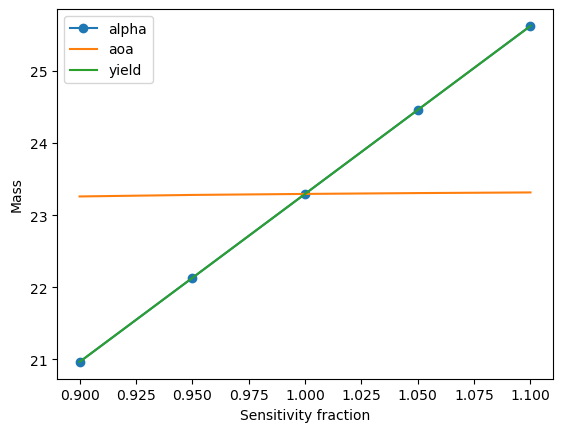

In [32]:
plt.plot(alpha_dict['input'], [row[-1] for row in alpha_dict['output']], marker='o', label='alpha')
plt.plot(aoa_dict['input'], [row[-1] for row in aoa_dict['output']], label='aoa')
plt.plot(np.array(factor_dict['input'])/2, [row[-1] for row in factor_dict['output']], label='yield')
plt.xlabel('Sensitivity fraction')
plt.ylabel('Mass')
plt.legend()
plt.show()

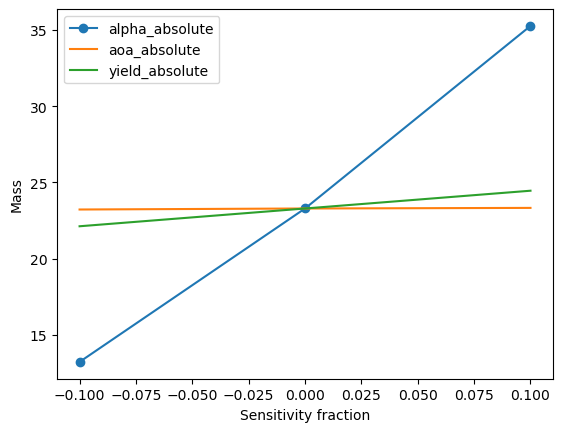

In [33]:
plt.plot(alpha_dict_absolute['input'], [row[-1] for row in alpha_dict_absolute['output']], marker='o', label='alpha_absolute')
plt.plot(aoa_dict_absolute['input'], [row[-1] for row in aoa_dict_absolute['output']], label='aoa_absolute')
plt.plot(np.array(factor_dict_absolute['input']), [row[-1] for row in factor_dict_absolute['output']], label='yield_absolute')
plt.xlabel('Sensitivity fraction')
plt.ylabel('Mass')
plt.legend()
plt.show()

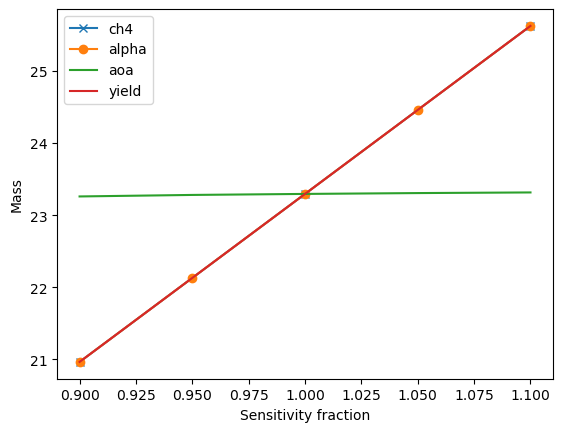

In [34]:

ch4_dict = {'100':90*np.ones(7),
            '500':100*np.ones(7),
            '1000':110*np.ones(7)}
ch4_data = []
for ch4 in ch4_dict.keys():
    m, c, d = calc_swv_mass_conc(ch4_dict[ch4])
    ch4_data.append(m)

plt.plot([0.9,1,1.1], [row[-1] for row in ch4_data], marker='x', label='ch4')
plt.plot(alpha_dict['input'], [row[-1] for row in alpha_dict['output']], marker='o', label='alpha')
plt.plot(aoa_dict['input'], [row[-1] for row in aoa_dict['output']], label='aoa')
plt.plot(np.array(factor_dict['input'])/2, [row[-1] for row in factor_dict['output']], label='yield')
plt.xlabel('Sensitivity fraction')
plt.ylabel('Mass')
plt.legend()
plt.show()
    


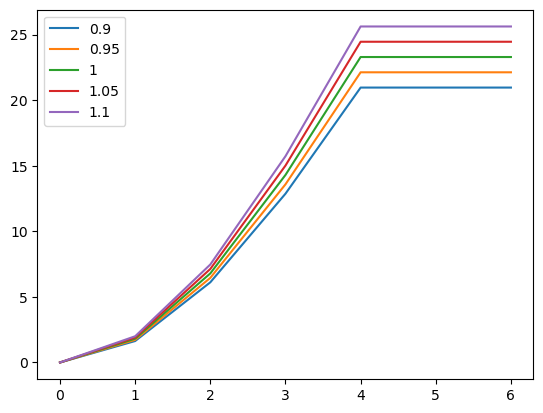

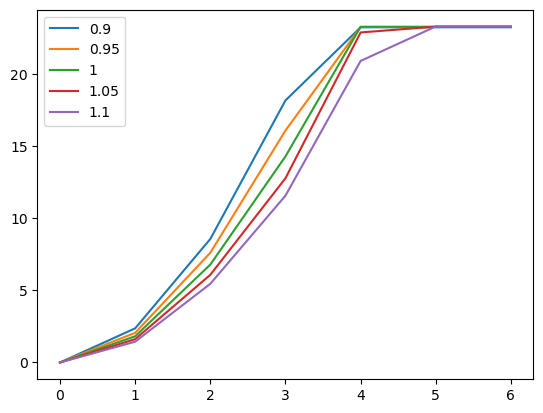

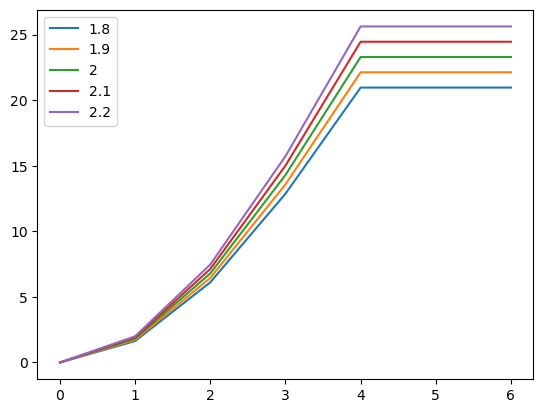

In [35]:
for j,i in enumerate(alpha_dict['output']):
    # print(i,j)
    plt.plot(range(len(i)), i, label= str(alpha_dict['input'][j]))
plt.legend()
plt.show()

for j,i in enumerate(aoa_dict['output']):
    # print(i,j)
    plt.plot(range(len(i)), i, label= str(aoa_dict['input'][j]))
plt.legend()
plt.show()

for j,i in enumerate(factor_dict['output']):
    # print(i,j)
    plt.plot(range(len(i)), i, label= str(factor_dict['input'][j]))
plt.legend()
plt.show()


In [36]:
# SENSITIVITY FROM SLIDE 23 PPT 4 

#S+ = (X+-X)/(dP/P) and with +=-
# for alpha:
X_min = alpha_dict['output'][0][-1]
X = alpha_dict['output'][2][-1]
X_plus = alpha_dict['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('alpha: ',S_min,S_plus)

#for aoa:
X_min = aoa_dict['output'][0][-1]
X = aoa_dict['output'][2][-1]
X_plus = aoa_dict['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('aoa: ',S_min,S_plus)

# for factor:
X_min = factor_dict['output'][0][-1]
X = factor_dict['output'][2][-1]
X_plus = factor_dict['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('factor: ',S_min,S_plus)


# FOR ABSOLUTE# for alpha:
X_min = alpha_dict_absolute['output'][0][-1]
X = alpha_dict_absolute['output'][1][-1]
X_plus = alpha_dict_absolute['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('alpha_absolute: ',S_min,S_plus)

#for aoa:
X_min = aoa_dict_absolute['output'][0][-1]
X = aoa_dict_absolute['output'][1][-1]
X_plus = aoa_dict_absolute['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('aoa_absolute: ',S_min,S_plus)

# for factor:
X_min = factor_dict_absolute['output'][0][-1]
X = factor_dict_absolute['output'][1][-1]
X_plus = factor_dict_absolute['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('factor_absolute: ',S_min,S_plus)

alpha:  -23.294599999999974 23.29460000000001
aoa:  -0.3500000000000014 0.20580000000002485
factor:  -23.294599999999974 23.29460000000001
alpha_absolute:  -100.55829999999997 119.6528
aoa_absolute:  -0.6676999999999822 0.38990000000001857
factor_absolute:  -11.647299999999987 11.647300000000023


In [37]:
aoa_dict

{'input': [0.9, 0.95, 1, 1.05, 1.1],
 'output': [array([ 0.     ,  2.3702 ,  8.57048, 18.18597, 23.25961, 23.25961,
         23.25961]),
  array([ 0.     ,  2.05848,  7.61309, 16.09457, 23.2806 , 23.2806 ,
         23.2806 ]),
  array([ 0.     ,  1.81823,  6.79411, 14.30097, 23.29461, 23.29461,
         23.29461]),
  array([ 0.     ,  1.61811,  6.08377, 12.78393, 22.90072, 23.30637,
         23.30637]),
  array([ 0.     ,  1.44291,  5.45976, 11.57602, 20.92512, 23.31519,
         23.31519])]}

In [38]:
def calc_swv_rf(total_swv_mass, rf_new=None):  # mass in Tg # TODO note that i adapted teh code to handle lists
    """
    Function to calculate the RF due to a certain SWV perturbation mass. Based on Pletzer (2024) #TODO fix citation

    Args:
        total_swv_mass (dict): A dict with the key "SWV" with an array with the SWV mass in Tg for corresponding year
    Raises:
        TypeError: if total_SWV_mass is not a dict
        ValueError: if the total mass is out of range of the plot of Pletzer (2024)

    Returns:
        rf_swv_dict (dict): A dict that contains the forcing due to SWV at that time
    """
    # based on the formula of Pletzer 2024
    # if not isinstance(total_swv_mass, dict):
    #     raise TypeError("total SWV mass must be a float or integer")

    rf_swv_list = []
    a = -0.00088
    b = 0.47373
    c = -0.74676
    for value in total_swv_mass:
        negative = False
        if value < 0:
            negative = True
            value = abs(value)
        if value > 160:
            raise ValueError("Total SWV mass out of range of Pletzer plot")
        if value < 1.6:
            # Make sure that values smaller than 1.6 Tg cause 0 impact instead of impact with the wrong sign
            rf_value = 0
        else:
            rf_value = (
                a * value**2 + b * value + c
            ) / 1000  # to make it W/m2 from mW/m2
        if negative == True:
            rf_value = rf_value * -1
        rf_swv_list.append(rf_value)
    rf_swv_array = np.array(rf_swv_list)
    #SENSITIVITY:
    if rf_new != None:
        rf_swv_array = rf_swv_array*rf_new
        
    rf_swv_dict = {"SWV": rf_swv_array}
    return rf_swv_dict
calc_swv_rf(aoa_dict['output'][1])


{'SWV': array([0.        , 0.00022467, 0.00280879, 0.00664977, 0.00980501,
        0.00980501, 0.00980501])}

In [39]:
alpha_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
aoa_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
factor_dict = {'input':[1.8, 1.9, 2, 2.1, 2.2], 'output':[]}
rf_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}

for alpha_new in alpha_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], alpha_new=alpha_new)
    print('alpha:', alpha_new, 'mass:', m[-1])
    alpha_dict['output'].append(m)
for aoa_new in aoa_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], aoa_new=aoa_new)
    print('aoa:', aoa_new, 'mass:', m[-1])
    aoa_dict['output'].append(m.round(0))
for factor_new in factor_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], factor_new=factor_new)
    print('factor:', factor_new, 'mass:', m[-1])
    factor_dict['output'].append(m)
for rf_new in rf_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100])
    rf = calc_swv_rf(m, rf_new=rf_new)
    rf_dict['output'].append(rf)


alpha: 0.9 mass: 20.965149587098267
alpha: 0.95 mass: 22.129880119714834
alpha: 1 mass: 23.29461065233141
alpha: 1.05 mass: 24.459341184947974
alpha: 1.1 mass: 25.624071717564547
aoa: 0.9 mass: 23.25960819931435
aoa: 0.95 mass: 23.28060461225799
aoa: 1 mass: 23.29461065233141
aoa: 1.05 mass: 23.30637046677214
aoa: 1.1 mass: 23.315187484545557
factor: 1.8 mass: 20.965149587098267
factor: 1.9 mass: 22.129880119714834
factor: 2 mass: 23.29461065233141
factor: 2.1 mass: 24.459341184947974
factor: 2.2 mass: 25.624071717564547


In [40]:
rf_dict

{'input': [0.9, 0.95, 1, 1.05, 1.1],
 'output': [{'SWV': array([0.        , 0.00010051, 0.00218808, 0.00526326, 0.00882997,
          0.00882997, 0.00882997])},
  {'SWV': array([0.        , 0.0001061 , 0.00230963, 0.00555566, 0.00932052,
          0.00932052, 0.00932052])},
  {'SWV': array([0.        , 0.00011168, 0.00243119, 0.00584806, 0.00981107,
          0.00981107, 0.00981107])},
  {'SWV': array([0.        , 0.00011726, 0.00255275, 0.00614047, 0.01030163,
          0.01030163, 0.01030163])},
  {'SWV': array([0.        , 0.00012285, 0.00267431, 0.00643287, 0.01079218,
          0.01079218, 0.01079218])}]}

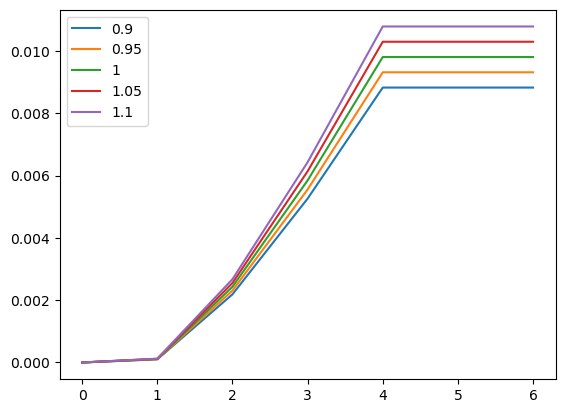

In [41]:
for j,i in enumerate(rf_dict['output']):
    # print(i,j)
    plt.plot(range(len(i['SWV'])), i['SWV'], label= str(rf_dict['input'][j]))
plt.legend()
plt.show()



0

10

20

30

40

50

60

70

80

90

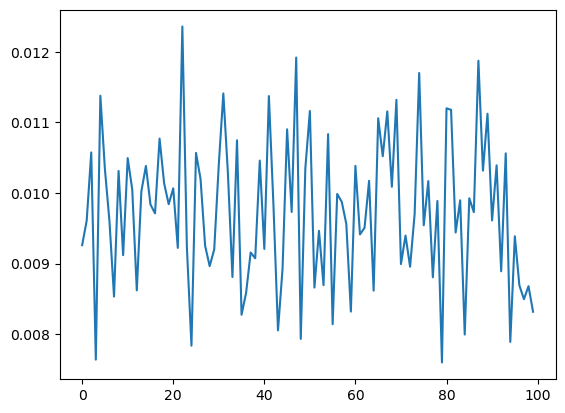

[np.float64(0.009260052001802008),
 np.float64(0.009609118282814558),
 np.float64(0.010573734561011657),
 np.float64(0.007638052530456152),
 np.float64(0.011377228761815735),
 np.float64(0.010335331989673157),
 np.float64(0.009598299499338056),
 np.float64(0.00853141082058863),
 np.float64(0.010311188354229662),
 np.float64(0.009118414106942304),
 np.float64(0.010493921246722772),
 np.float64(0.010048920922195476),
 np.float64(0.00861923486289395),
 np.float64(0.01002177874222352),
 np.float64(0.010382346547767735),
 np.float64(0.009836422003674052),
 np.float64(0.0097109840704682),
 np.float64(0.01076978397440228),
 np.float64(0.010137324931147102),
 np.float64(0.009839895777043268),
 np.float64(0.010065315290678105),
 np.float64(0.009221111000999373),
 np.float64(0.012358403301585818),
 np.float64(0.009223834014390496),
 np.float64(0.007835779520139419),
 np.float64(0.01056740210176157),
 np.float64(0.010195916991740439),
 np.float64(0.009251117873121408),
 np.float64(0.0089628685767

In [42]:
#COMBINE
data = []
for i in range(100):
    if i%10 == 0:
        display(i)
    alpha_sample  = random.uniform(0.9, 1.1) #random.choice(alpha_dict['input'])
    aoa_sample    = random.uniform(0.9, 1.1) #random.choice(aoa_dict['input'])
    factor_sample = random.uniform(1.8, 2.2) #random.choice(factor_dict['input'])
    rf_sample = random.uniform(0.9, 1.1)     #random.choice(rf_dict['input'])
    
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], alpha_new=alpha_sample, aoa_new=aoa_sample,factor_new=factor_sample)
    rf = calc_swv_rf(m, rf_new=rf_sample)
    data.append(rf['SWV'][-1])
plt.plot(range(len(data)), data)
plt.show()
data


0

10

20

30

40

50

The run can be stopped as c_v stabalizes. Number of tuns = 51
100 [np.float64(7.236832272815367), np.float64(7.168283157813707), np.float64(7.225192806771594), np.float64(7.110519698459813), np.float64(7.155060709888366)]


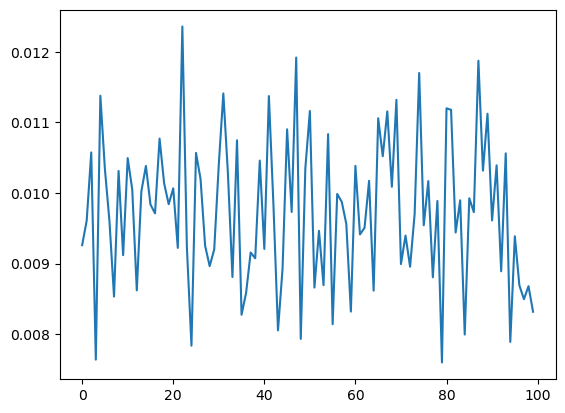

0

10

20

30

40

ValueError: Total SWV mass out of range of Pletzer plot

In [43]:
# FOR DIFFERENT CH4|e
ch4_dict = {'100':[100,100,100,100,100,100,100],
            '500':[500,500,500,500,500,500,500],
            '1000':[1000,1000,1000,1000,1000,1000,1000]}

data_dict= {'100':[],
            '500':[],
            '1000':[]}
for conc in ch4_dict.keys():
    
    c_v_list = []
    for i in range(100):
        if i%10 == 0:
            display(i)
        alpha_sample  = np.random.normal(1, 0.1)
        aoa_sample    = np.random.normal(1, 0.1)
        factor_sample = random.choice(factor_dict['input'])
        rf_sample = random.choice(rf_dict['input'])
        try:
            m, c, d = calc_swv_mass_conc(ch4_dict[conc], alpha_new=alpha_sample, aoa_new=aoa_sample,factor_new=factor_sample)
        except ValueError:
            print('ValueError')
            break
        rf = calc_swv_rf(m, rf_new=rf_sample)
        data_dict[conc].append(rf['SWV'][-1])
        mu = np.mean(data_dict[conc])
        sigma = np.std(data_dict[conc])
        if i == 0:
            continue
        c_v = mu/sigma
        if i > 10:
            
            if abs(c_v-max(c_v_list[-5:])) < c_v*0.01 and abs(c_v-min(c_v_list[-5:])) < c_v*0.01:
                print('The run can be stopped as c_v stabalizes. Number of tuns =', i)
                break
        c_v_list.append(c_v)
    print(conc, c_v_list[-5:])
    plt.plot(range(len(data)), data)
    plt.show()


In [ ]:
data_dict

In [ ]:
mu = np.mean(data)
sigma = np.std(data)

print("Mean (mu):", mu)
print("Std (sigma):", sigma)
print("Std in % of mean:", sigma/mu*100)



In [ ]:
plt.scatter(np.ones(len(data)), data)


In [ ]:
for conc in data_dict.keys():
    if conc == '1000':
        continue
    mu = np.mean(data_dict[conc])
    sigma = np.std(data_dict[conc])
    
    print("Mean (mu):", mu)
    print("Std (sigma):", sigma)
    print("Std in % of mean:", sigma/mu*100)
    
    
    plt.hist(data_dict[conc], bins=9, density=True, alpha=0.6)
    
    # Smooth normal distribution fit using mu and sigma
    x = np.linspace(min(data_dict[conc]), max(data_dict[conc]), 200)
    plt.plot(x, 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2)))
    
    plt.xlabel("RF value")
    plt.ylabel("Density")
    plt.title("RF Distribution with Normal Fit"+ conc)
    plt.show()

In [ ]:
plt.hist(data, bins=10)
plt.xlabel("RF value")
plt.ylabel("Frequency")
plt.title("Distribution of RF values")
plt.show()

In [ ]:

plt.hist(data, bins=9, density=True, alpha=0.6)

# Smooth normal distribution fit using mu and sigma
x = np.linspace(min(data), max(data), 200)
plt.plot(x, 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2)))

plt.xlabel("RF value")
plt.ylabel("Density")
plt.title("RF Distribution with Normal Fit")
plt.show()

In [ ]:
dd = [np.float64(0.00972449560190064), np.float64(0.008831809632730246), np.float64(0.011937966604203246), np.float64(0.007507969592932361), np.float64(0.010214431825970987), np.float64(0.009744410861399499), np.float64(0.0101930680895098), np.float64(0.010241793647514397), np.float64(0.009758277316992647), np.float64(0.008346177518720995), np.float64(0.009176407280250664), np.float64(0.009718416422396046), np.float64(0.010207797637496747), np.float64(0.010234313400879118), np.float64(0.009758708253558911), np.float64(0.008330468017196545), np.float64(0.010156966872899827), np.float64(0.009701941803576508), np.float64(0.010285614286245996), np.float64(0.009272026024077366), np.float64(0.011357467919002204), np.float64(0.010223220301746364), np.float64(0.008267653619653873), np.float64(0.011303363555945403), np.float64(0.011365232579431032), np.float64(0.00970350719933668), np.float64(0.00872760224971953), np.float64(0.009219665335208441), np.float64(0.010728567125735665), np.float64(0.010307561512224082), np.float64(0.008338723035554352), np.float64(0.010217285213522758), np.float64(0.008746574780156441), np.float64(0.00924509202968739), np.float64(0.009713921918467695), np.float64(0.009774394969953882), np.float64(0.010826962406574733), np.float64(0.010207797637496747), np.float64(0.010207797637496747), np.float64(0.007943981502290762), np.float64(0.010841219377229377), np.float64(0.00972449560190064), np.float64(0.010282171842331702), np.float64(0.010244072594676044), np.float64(0.010822939587835288), np.float64(0.009683179624461191), np.float64(0.0101930680895098), np.float64(0.010275785050859456), np.float64(0.009160928514360294), np.float64(0.009714353192723454), np.float64(0.009291405838146435), np.float64(0.009662955820697568), np.float64(0.009718416422396046), np.float64(0.009251953836312853), np.float64(0.008802015605312987), np.float64(0.009314762025086853), np.float64(0.008826835546239113), np.float64(0.011359133668607071), np.float64(0.011932704014670012), np.float64(0.008826835546239113), np.float64(0.007497912574681669), np.float64(0.009686992435073262), np.float64(0.010850859641529077), np.float64(0.008671978023713875), np.float64(0.011358146036424552), np.float64(0.008798606600974418), np.float64(0.008759297858421087), np.float64(0.011352539126136398), np.float64(0.010310976433492349), np.float64(0.009789092866919107), np.float64(0.00874291787345111), np.float64(0.00791918388834176), np.float64(0.010283369017250214), np.float64(0.008389296202313008), np.float64(0.01190384184452318), np.float64(0.010713457660070863), np.float64(0.01134936869552332), np.float64(0.009798200680243518), np.float64(0.00826124516752366), np.float64(0.008273291813883442), np.float64(0.009216844713397681), np.float64(0.010725017522539898), np.float64(0.01027187085999226), np.float64(0.010687908118995984), np.float64(0.009306129646330555), np.float64(0.00968768405257584), np.float64(0.009787138580970552), np.float64(0.00879909320926862), np.float64(0.009683179624461191), np.float64(0.009718416422396046), np.float64(0.01081987415361106), np.float64(0.008803820869229402), np.float64(0.00882344903032425), np.float64(0.011366792985223856), np.float64(0.009805012657986162), np.float64(0.009724701816127255), np.float64(0.008667258090735035), np.float64(0.009320520000881568), np.float64(0.010824031028029554), np.float64(0.008761921121990077), np.float64(0.009686992435073262), np.float64(0.009223730556120404), np.float64(0.009774752571116216), np.float64(0.010265041034470155), np.float64(0.008831809632730246), np.float64(0.009774394969953882), np.float64(0.010776088564772872), np.float64(0.010275785050859456), np.float64(0.009718879353395968), np.float64(0.008363629825767932), np.float64(0.007933412871366159), np.float64(0.013112693153676924), np.float64(0.010806481897714161), np.float64(0.010308316659452622), np.float64(0.007480258036829695), np.float64(0.009276805361001674), np.float64(0.012500928015368585), np.float64(0.010835173955234895), np.float64(0.010217285213522758), np.float64(0.008334916779905607), np.float64(0.00980872229368372), np.float64(0.011345485452148463), np.float64(0.011375244102857012), np.float64(0.010720641105997106), np.float64(0.010299539380524851), np.float64(0.010760692482773272), np.float64(0.010187038893755334), np.float64(0.008740011263616829), np.float64(0.011944006307999864), np.float64(0.00970467056611123), np.float64(0.011355046090018457), np.float64(0.010241793647514397), np.float64(0.013112693153676924), np.float64(0.008358353950534194), np.float64(0.008385313807973582), np.float64(0.009239047869732052), np.float64(0.008809200723007003), np.float64(0.009751989430501125), np.float64(0.010261054693731099), np.float64(0.008346177518720995), np.float64(0.012516661646691608), np.float64(0.010835543811667916), np.float64(0.010806481897714161), np.float64(0.009248206545773512), np.float64(0.01023011368670147), np.float64(0.008816333349155265), np.float64(0.008797277314004594), np.float64(0.008804982221999153), np.float64(0.010725017522539898), np.float64(0.008845185422853341), np.float64(0.01031031103673042), np.float64(0.00971112362624092), np.float64(0.009758277316992647), np.float64(0.009294147900999104), np.float64(0.010295263290885471), np.float64(0.009242858477498119), np.float64(0.00931436307296062), np.float64(0.00791385914571185), np.float64(0.007918440584716606), np.float64(0.008342188436591512), np.float64(0.009761995798316483), np.float64(0.010273613129064317), np.float64(0.01130864975229702), np.float64(0.009284514597308129), np.float64(0.007507969592932361), np.float64(0.009233606248090751), np.float64(0.010187566821038765), np.float64(0.009219437037805667), np.float64(0.008771925935686212), np.float64(0.01029376662108452), np.float64(0.010687908118995984), np.float64(0.007506158877052462), np.float64(0.008353517987140284), np.float64(0.010320729709414925), np.float64(0.007925854678006822), np.float64(0.009240373748805231), np.float64(0.01136831052690347), np.float64(0.00929088018665698), np.float64(0.009225774750748247), np.float64(0.009308947590432267), np.float64(0.008363629825767932), np.float64(0.00879317682856872), np.float64(0.009731868964942242), np.float64(0.009811073685138493), np.float64(0.010841219377229377), np.float64(0.009313340527568749), np.float64(0.009742273875990358), np.float64(0.010822939587835288), np.float64(0.009229522619359288), np.float64(0.009783313579999058), np.float64(0.009222299700032676), np.float64(0.009255648349927184), np.float64(0.01136831052690347), np.float64(0.01191909819283471), np.float64(0.010768002153611018), np.float64(0.01250741462366329), np.float64(0.009246830457674625), np.float64(0.010301627369395418), np.float64(0.009794795484893898), np.float64(0.007918440584716606), np.float64(0.010275785050859456), np.float64(0.009222299700032676), np.float64(0.010273613129064317), np.float64(0.009811073685138493), np.float64(0.011355046090018457), np.float64(0.009203299849947047), np.float64(0.010766800883675227), np.float64(0.01126847985414365), np.float64(0.007925721083241759), np.float64(0.007918440584716606), np.float64(0.010182202624672785), np.float64(0.009287841084551843), np.float64(0.009151642383691155), np.float64(0.009287291961629909), np.float64(0.008761921121990077), np.float64(0.009287841084551843), np.float64(0.01017714921994414), np.float64(0.011937966604203246), np.float64(0.010766800883675227), np.float64(0.007501079012627975), np.float64(0.01128716016310421), np.float64(0.010656452457833424), np.float64(0.010825826588566942), np.float64(0.007918440584716606), np.float64(0.009291405838146435), np.float64(0.011916686136155442), np.float64(0.009244627479090202), np.float64(0.009792394925096747), np.float64(0.010756276224409847), np.float64(0.008736915505294115), np.float64(0.010656452457833424), np.float64(0.007907806929212783), np.float64(0.01250741462366329), np.float64(0.007933412871366159), np.float64(0.009325354285139186), np.float64(0.010776088564772872), np.float64(0.010307561512224082), np.float64(0.008718915647318255), np.float64(0.00923239876338742), np.float64(0.010304107298931185), np.float64(0.010791176985176718), np.float64(0.010174878565706836), np.float64(0.010285767020366135), np.float64(0.01136448001397144), np.float64(0.01194281609641165), np.float64(0.010776088564772872), np.float64(0.009788000803341114), np.float64(0.010169090226999222), np.float64(0.011332476251650115), np.float64(0.010230086969215681), np.float64(0.008736915505294115), np.float64(0.009794795484893898), np.float64(0.008373076868244376), np.float64(0.011303363555945403), np.float64(0.00879317682856872), np.float64(0.010282014671351584), np.float64(0.009212469041370614), np.float64(0.011383701420580098), np.float64(0.009240373748805231), np.float64(0.011324598632720978), np.float64(0.010204337243515849), np.float64(0.008826835546239113), np.float64(0.008780715553623213), np.float64(0.00834017653005829), np.float64(0.00929088018665698), np.float64(0.009730384156508736), np.float64(0.007091392983328664), np.float64(0.010774107428417654), np.float64(0.010822939587835288), np.float64(0.010826962406574733), np.float64(0.008363629825767932), np.float64(0.008353122690683857), np.float64(0.007920309501355138), np.float64(0.010187038893755334), np.float64(0.011280527645883574), np.float64(0.007918440584716606), np.float64(0.009672494511425593), np.float64(0.009164115369055374), np.float64(0.010814329609541387), np.float64(0.010244674580325625), np.float64(0.007879325537031849), np.float64(0.009298600763174058), np.float64(0.010728567125735665), np.float64(0.01128716016310421), np.float64(0.008806505197785357), np.float64(0.011885746664155534), np.float64(0.010776088564772872), np.float64(0.010261054693731099), np.float64(0.007928868642784945), np.float64(0.01069025806463565), np.float64(0.008375277875663802), np.float64(0.010768002153611018), np.float64(0.010835543811667916), np.float64(0.010320729709414925), np.float64(0.010768002153611018), np.float64(0.007511559766848895), np.float64(0.01022054642196108), np.float64(0.010272324477430433), np.float64(0.007497912574681669), np.float64(0.010313895452887915), np.float64(0.010728567125735665), np.float64(0.00923494922435799), np.float64(0.008731747623218857), np.float64(0.013108354749770987), np.float64(0.009757458360497228), np.float64(0.009758277316992647), np.float64(0.009242858477498119), np.float64(0.007922601510922793), np.float64(0.00931072149774036), np.float64(0.00923239876338742), np.float64(0.009665097357926736), np.float64(0.008798353163624387), np.float64(0.011357467919002204), np.float64(0.011909835497266054), np.float64(0.009726953063073399), np.float64(0.00981616240540967), np.float64(0.009288656738473433), np.float64(0.009705001401373025), np.float64(0.011920630139706293), np.float64(0.011935945605681985), np.float64(0.00931436307296062), np.float64(0.012503472283746243), np.float64(0.011359133668607071), np.float64(0.008739173684376742), np.float64(0.009291405838146435), np.float64(0.00878935614449721), np.float64(0.010693883239282307), np.float64(0.009248206545773512), np.float64(0.009305864306293113), np.float64(0.011393402623605532), np.float64(0.008794378778571282), np.float64(0.007859821344923704), np.float64(0.010156966872899827), np.float64(0.008359056976096658), np.float64(0.009754654963230051), np.float64(0.009696393509447527), np.float64(0.010797824830493345), np.float64(0.008739173684376742), np.float64(0.011299057945991488), np.float64(0.008363629825767932), np.float64(0.00882344903032425), np.float64(0.008338751626085989), np.float64(0.009803252626164903), np.float64(0.011352114849260193), np.float64(0.009233606248090751), np.float64(0.009793684778333537), np.float64(0.01126847985414365), np.float64(0.008797277314004594), np.float64(0.010776088564772872), np.float64(0.007911710989674798), np.float64(0.010675137622722352), np.float64(0.009155324812204206), np.float64(0.008326758452681568), np.float64(0.00834528002696608), np.float64(0.011935132634485049), np.float64(0.011383701420580098), np.float64(0.008837979800136299), np.float64(0.010239842349475494), np.float64(0.009261424382762513), np.float64(0.011294863641634798), np.float64(0.00923494922435799), np.float64(0.009787138580970552), np.float64(0.011927090352037425), np.float64(0.010675137622722352), np.float64(0.010756276224409847), np.float64(0.008654637794548597), np.float64(0.011896969790606443), np.float64(0.010233760616743127), np.float64(0.010753852512302067), np.float64(0.011926053338245781), np.float64(0.009155324812204206), np.float64(0.007943981502290762), np.float64(0.008771925935686212), np.float64(0.009752233138779435), np.float64(0.011280527645883574), np.float64(0.010313895452887915), np.float64(0.010728567125735665), np.float64(0.011280527645883574), np.float64(0.010846428735717038), np.float64(0.00922863553308728), np.float64(0.009225567444928874), np.float64(0.01027740084350817), np.float64(0.007879325537031849), np.float64(0.00791780562444064), np.float64(0.009243035096076591), np.float64(0.00921648335508639), np.float64(0.012511521624812205), np.float64(0.0107072728115458), np.float64(0.009313340527568749), np.float64(0.01128716016310421), np.float64(0.009774394969953882), np.float64(0.008380301672154405), np.float64(0.008353517987140284), np.float64(0.01128716016310421), np.float64(0.00834528002696608), np.float64(0.012508605267741144), np.float64(0.010228032012574296), np.float64(0.010753852512302067), np.float64(0.012503472283746243), np.float64(0.00879909320926862), np.float64(0.008273291813883442), np.float64(0.008824511392187546), np.float64(0.008731747623218857), np.float64(0.010814329609541387), np.float64(0.011294863641634798), np.float64(0.009751989430501125), np.float64(0.008338751626085989), np.float64(0.00931072149774036), np.float64(0.010226305890529759), np.float64(0.009287291961629909), np.float64(0.007920309501355138), np.float64(0.011368479338299415), np.float64(0.010299539380524851), np.float64(0.011909835497266054), np.float64(0.010285614286245996), np.float64(0.010825826588566942), np.float64(0.00874291787345111), np.float64(0.008335281944486262), np.float64(0.010310976433492349), np.float64(0.007939233163093647), np.float64(0.010774107428417654), np.float64(0.008747564670461947), np.float64(0.009287418078806328), np.float64(0.008826646113656402), np.float64(0.00923494922435799), np.float64(0.00882344903032425), np.float64(0.01250741462366329), np.float64(0.008385313807973582), np.float64(0.010207797637496747), np.float64(0.010282829476628076), np.float64(0.007925854678006822), np.float64(0.01027247925899901), np.float64(0.010825826588566942), np.float64(0.008763486394657044), np.float64(0.008323022556549278), np.float64(0.008790327195163867), np.float64(0.010169090226999222), np.float64(0.011900758232218278), np.float64(0.009308947590432267), np.float64(0.009744410861399499), np.float64(0.010656452457833424), np.float64(0.008757185356561205), np.float64(0.010271570097192668), np.float64(0.010310976433492349), np.float64(0.011393402623605532), np.float64(0.009267978419339223), np.float64(0.00924125207042847), np.float64(0.008344686782847692), np.float64(0.008358353950534194), np.float64(0.007086560245417606), np.float64(0.010753852512302067), np.float64(0.007922601510922793), np.float64(0.010265041034470155), np.float64(0.011352114849260193), np.float64(0.008277797204454153), np.float64(0.0130942260289755), np.float64(0.010298065607621481), np.float64(0.010241793647514397), np.float64(0.009179155461132462), np.float64(0.00922863553308728), np.float64(0.011293790137428615), np.float64(0.010841620400552475), np.float64(0.010253666704331322), np.float64(0.009261424382762513), np.float64(0.008373076868244376), np.float64(0.010191807542993987), np.float64(0.01138875017250289), np.float64(0.007511559766848895), np.float64(0.008798353163624387), np.float64(0.011932704014670012), np.float64(0.008740011263616829), np.float64(0.008718915647318255), np.float64(0.00970467056611123), np.float64(0.011341342140403462), np.float64(0.010267081943116922), np.float64(0.009726953063073399), np.float64(0.009160928514360294), np.float64(0.007480258036829695), np.float64(0.00972449560190064), np.float64(0.010756276224409847), np.float64(0.009240373748805231), np.float64(0.01135552022813631), np.float64(0.008837979800136299), np.float64(0.011888498188200822), np.float64(0.009755976130053757), np.float64(0.008734203509500106), np.float64(0.009751989430501125), np.float64(0.009255648349927184), np.float64(0.01136448001397144), np.float64(0.009752233138779435), np.float64(0.009303418742493751), np.float64(0.007899842875788335), np.float64(0.010323200207396644), np.float64(0.00974426616591726), np.float64(0.010752227828227838), np.float64(0.008739173684376742), np.float64(0.010207797637496747), np.float64(0.008744652097360351), np.float64(0.00834528002696608), np.float64(0.009255648349927184), np.float64(0.009287418078806328), np.float64(0.011279033374764455), np.float64(0.010682235988865014), np.float64(0.010781460748833216), np.float64(0.008310245623281677), np.float64(0.007474459913473787), np.float64(0.01194281609641165), np.float64(0.010725017522539898), np.float64(0.008746574780156441), np.float64(0.011332476251650115), np.float64(0.008739173684376742), np.float64(0.008331013971868521), np.float64(0.008735658638977921), np.float64(0.007911710989674798), np.float64(0.010271570097192668), np.float64(0.00872760224971953), np.float64(0.009160928514360294), np.float64(0.00973698400817859), np.float64(0.007933412871366159), np.float64(0.010187038893755334), np.float64(0.010174878565706836), np.float64(0.009229522619359288), np.float64(0.008734203509500106), np.float64(0.010675137622722352), np.float64(0.00922863553308728), np.float64(0.010236699511209986), np.float64(0.009787138580970552), np.float64(0.008809200723007003), np.float64(0.009303418742493751), np.float64(0.009712384085447435), np.float64(0.010230086969215681), np.float64(0.00879317682856872), np.float64(0.010172068255204633), np.float64(0.012503472283746243), np.float64(0.009292473751910894), np.float64(0.010825826588566942), np.float64(0.010319213290699899), np.float64(0.010672135983934159), np.float64(0.0107072728115458), np.float64(0.009249889605188032), np.float64(0.009229522619359288), np.float64(0.00923494922435799), np.float64(0.009795925943505849), np.float64(0.01135113461976989), np.float64(0.009232835669997157), np.float64(0.010267339344355255), np.float64(0.011368479338299415), np.float64(0.013108354749770987), np.float64(0.010785940701301955), np.float64(0.010773053256166891), np.float64(0.009267978419339223), np.float64(0.008809200723007003), np.float64(0.008782396105135691), np.float64(0.008353517987140284), np.float64(0.008744522672798462), np.float64(0.01130864975229702), np.float64(0.009294147900999104), np.float64(0.00879909320926862), np.float64(0.010774107428417654), np.float64(0.010753852512302067), np.float64(0.008746574780156441), np.float64(0.010261054693731099), np.float64(0.009243035096076591), np.float64(0.009726953063073399), np.float64(0.008736915505294115), np.float64(0.010261054693731099), np.float64(0.011347740063376603), np.float64(0.010780436040272769), np.float64(0.010774107428417654), np.float64(0.009244011912690872), np.float64(0.00917419418306412), np.float64(0.010324970835456549), np.float64(0.009714353192723454), np.float64(0.010217285213522758), np.float64(0.010267081943116922), np.float64(0.009276805361001674), np.float64(0.010307561512224082), np.float64(0.010774107428417654), np.float64(0.01191909819283471), np.float64(0.00882344903032425), np.float64(0.0107072728115458), np.float64(0.012499033936749341), np.float64(0.010796256013272868), np.float64(0.008380301672154405), np.float64(0.007933412871366159), np.float64(0.009718416422396046), np.float64(0.010792181053652343), np.float64(0.00968768405257584), np.float64(0.008790327195163867), np.float64(0.008810183580227197), np.float64(0.00878739512492863), np.float64(0.010286266357283195), np.float64(0.010806481897714161), np.float64(0.007920309501355138), np.float64(0.010187120508773519), np.float64(0.011900758232218278), np.float64(0.010678452284248362), np.float64(0.007466830277677518), np.float64(0.009249889605188032), np.float64(0.008813155432587072), np.float64(0.008385313807973582), np.float64(0.010204337243515849), np.float64(0.008273291813883442), np.float64(0.007873955828241784), np.float64(0.010239842349475494), np.float64(0.009225567444928874), np.float64(0.011909835497266054), np.float64(0.00923494922435799), np.float64(0.0101930680895098), np.float64(0.009771157521607768), np.float64(0.008359056976096658), np.float64(0.010811537951676374), np.float64(0.009761785862145335), np.float64(0.010814329609541387), np.float64(0.008806505197785357), np.float64(0.010829590225532312), np.float64(0.010752227828227838), np.float64(0.009246830457674625), np.float64(0.010785464402991874), np.float64(0.009300079062923346), np.float64(0.008366977546797076), np.float64(0.00976577367737617), np.float64(0.01027187085999226), np.float64(0.00921648335508639), np.float64(0.010693883239282307), np.float64(0.010841219377229377), np.float64(0.008798606600974418), np.float64(0.008366038921199635), np.float64(0.010232542803602782), np.float64(0.011900758232218278), np.float64(0.011383701420580098), np.float64(0.007859821344923704), np.float64(0.00922863553308728), np.float64(0.010682235988865014), np.float64(0.009303418742493751), np.float64(0.008363629825767932), np.float64(0.007873955828241784), np.float64(0.010257933588968678), np.float64(0.008813155432587072), np.float64(0.00970350719933668), np.float64(0.010822939587835288), np.float64(0.009222299700032676), np.float64(0.008654637794548597), np.float64(0.009672036799739204), np.float64(0.01066706941632387), np.float64(0.008310245623281677), np.float64(0.009712384085447435), np.float64(0.010796256013272868), np.float64(0.010675137622722352), np.float64(0.010841620400552475), np.float64(0.010767776389252503), np.float64(0.009655363514852409), np.float64(0.009811073685138493), np.float64(0.008746574780156441), np.float64(0.009774394969953882), np.float64(0.00749072030089435), np.float64(0.010278880445930507), np.float64(0.008831809632730246), np.float64(0.008744652097360351), np.float64(0.00921648335508639), np.float64(0.009672494511425593), np.float64(0.010313895452887915), np.float64(0.010236450736922425), np.float64(0.00931072149774036), np.float64(0.009742273875990358), np.float64(0.012506441204403402), np.float64(0.008654637794548597), np.float64(0.008763486394657044), np.float64(0.010768002153611018), np.float64(0.010835173955234895), np.float64(0.008749540832140069), np.float64(0.012499033936749341), np.float64(0.008389296202313008), np.float64(0.009267978419339223), np.float64(0.011375244102857012), np.float64(0.009792183436612877), np.float64(0.009742273875990358), np.float64(0.007511559766848895), np.float64(0.008804202940450858), np.float64(0.009811073685138493), np.float64(0.010687908118995984), np.float64(0.01138875017250289), np.float64(0.008736915505294115), np.float64(0.008802015605312987), np.float64(0.009151642383691155), np.float64(0.010182202624672785), np.float64(0.008671978023713875), np.float64(0.010187566821038765), np.float64(0.011916686136155442), np.float64(0.010797824830493345), np.float64(0.009705001401373025), np.float64(0.011935132634485049), np.float64(0.008359138548805189), np.float64(0.007914463273275095), np.float64(0.010299539380524851), np.float64(0.009308947590432267), np.float64(0.010801017403802937), np.float64(0.008790327195163867), np.float64(0.011925782440607723), np.float64(0.009800320963825247), np.float64(0.00973289664858725), np.float64(0.0096973358330217), np.float64(0.009684202956152344), np.float64(0.010223220301746364), np.float64(0.012495047035467778), np.float64(0.011888498188200822), np.float64(0.007867852540498724), np.float64(0.00923239876338742), np.float64(0.009249889605188032), np.float64(0.008751258848065971), np.float64(0.009222299700032676), np.float64(0.010841219377229377), np.float64(0.010241793647514397), np.float64(0.00930277517884191), np.float64(0.011338317663446491), np.float64(0.00929332532603146), np.float64(0.010278547510265064), np.float64(0.009720102860526155), np.float64(0.01134936869552332), np.float64(0.007899842875788335), np.float64(0.010216625193007027), np.float64(0.009655363514852409), np.float64(0.00972406957655654), np.float64(0.008816333349155265), np.float64(0.012516661646691608), np.float64(0.009303418742493751), np.float64(0.010182202624672785), np.float64(0.009286014942560405), np.float64(0.010301627369395418), np.float64(0.010223220301746364), np.float64(0.009716280108178167), np.float64(0.010191807542993987), np.float64(0.008338723035554352), np.float64(0.009238180682169373), np.float64(0.011927090352037425), np.float64(0.007501079012627975), np.float64(0.010320729709414925), np.float64(0.01135280268035642), np.float64(0.010264963028134323), np.float64(0.00970467056611123), np.float64(0.010261054693731099), np.float64(0.008806505197785357), np.float64(0.01025502513262143), np.float64(0.009232495601276243), np.float64(0.010174878565706836), np.float64(0.007511559766848895), np.float64(0.00834528002696608), np.float64(0.010285614286245996), np.float64(0.008794378778571282), np.float64(0.007883616385194431), np.float64(0.010232542803602782), np.float64(0.008821370181215163), np.float64(0.010743733238533615), np.float64(0.011916686136155442), np.float64(0.009276805361001674), np.float64(0.009256075574662827), np.float64(0.008840571090978458), np.float64(0.010693883239282307), np.float64(0.011359814676208356), np.float64(0.010831933696859485), np.float64(0.009761473804596587), np.float64(0.007091392983328664), np.float64(0.009686992435073262), np.float64(0.010277927564188511), np.float64(0.009686992435073262), np.float64(0.008792760727035638), np.float64(0.007939233163093647), np.float64(0.011920630139706293), np.float64(0.011377321002251313), np.float64(0.012512520442963214), np.float64(0.010308316659452622), np.float64(0.00977625757262738), np.float64(0.011888498188200822), np.float64(0.010244072594676044), np.float64(0.010233760616743127), np.float64(0.010253666704331322), np.float64(0.008310245623281677), np.float64(0.00968768405257584), np.float64(0.009780081226608651), np.float64(0.007873955828241784), np.float64(0.008735658638977921), np.float64(0.010826962406574733), np.float64(0.00969528656049529), np.float64(0.010189904094416792), np.float64(0.009761785862145335), np.float64(0.008318572629748307), np.float64(0.009724701816127255), np.float64(0.010827123179332775), np.float64(0.010202094113587076), np.float64(0.01078957430340243), np.float64(0.009804693223944179), np.float64(0.011900758232218278), np.float64(0.008334532236253306), np.float64(0.01135113461976989), np.float64(0.007923438782306462), np.float64(0.00922863553308728), np.float64(0.009748001959044544), np.float64(0.010275785050859456), np.float64(0.011357467919002204), np.float64(0.007466830277677518), np.float64(0.00748943556593471), np.float64(0.009284514597308129), np.float64(0.010780436040272769), np.float64(0.01066706941632387), np.float64(0.011358146036424552), np.float64(0.009684202956152344), np.float64(0.010812968888002556), np.float64(0.007925721083241759), np.float64(0.00748943556593471), np.float64(0.009696393509447527), np.float64(0.007928868642784945), np.float64(0.007859821344923704), np.float64(0.010174878565706836), np.float64(0.00834528002696608), np.float64(0.009248206545773512), np.float64(0.010678452284248362), np.float64(0.008843500210910652), np.float64(0.01130212130107612), np.float64(0.010278880445930507), np.float64(0.010814329609541387), np.float64(0.009819977555706998), np.float64(0.007091392983328664), np.float64(0.010324970835456549), np.float64(0.011374110568011095), np.float64(0.009170884685779635), np.float64(0.008718915647318255), np.float64(0.007943981502290762), np.float64(0.008331013971868521), np.float64(0.009718416422396046), np.float64(0.007495305148112967), np.float64(0.007928868642784945), np.float64(0.009696393509447527), np.float64(0.010236450736922425), np.float64(0.010841620400552475), np.float64(0.007925854678006822), np.float64(0.012508605267741144), np.float64(0.009754654963230051), np.float64(0.01137145933431013), np.float64(0.009811073685138493), np.float64(0.010811537951676374), np.float64(0.008353517987140284), np.float64(0.011911823451107896), np.float64(0.010265041034470155), np.float64(0.00874291787345111), np.float64(0.009306621942303844), np.float64(0.007086560245417606), np.float64(0.010226305890529759), np.float64(0.00922863553308728), np.float64(0.008794378778571282), np.float64(0.0070810672864488515), np.float64(0.009728543563766987), np.float64(0.010239842349475494), np.float64(0.011877607313542681), np.float64(0.008362746039307391), np.float64(0.008346177518720995), np.float64(0.00791780562444064), np.float64(0.010822939587835288), np.float64(0.009776229556638242), np.float64(0.011303363555945403), np.float64(0.008334532236253306), np.float64(0.01134936869552332), np.float64(0.008334916779905607), np.float64(0.009740983369114756), np.float64(0.009232835669997157), np.float64(0.009306621942303844), np.float64(0.007511559766848895), np.float64(0.009752233138779435), np.float64(0.009306621942303844), np.float64(0.009216844713397681), np.float64(0.009701941803576508), np.float64(0.010836766194885671), np.float64(0.009672036799739204), np.float64(0.01138875017250289), np.float64(0.00875402629097147), np.float64(0.010255381727691177), np.float64(0.008330468017196545), np.float64(0.009179155461132462), np.float64(0.011892691746844012), np.float64(0.008746574780156441), np.float64(0.009222299700032676), np.float64(0.008835075109777178), np.float64(0.010761644937998964), np.float64(0.009244627479090202), np.float64(0.008319674894264686), np.float64(0.008845185422853341), np.float64(0.010261054693731099), np.float64(0.009783162327240406), np.float64(0.008798606600974418), np.float64(0.01136448001397144), np.float64(0.010257933588968678), np.float64(0.010245799380256682), np.float64(0.009308947590432267), np.float64(0.008334916779905607), np.float64(0.010307561512224082), np.float64(0.011358146036424552), np.float64(0.010204337243515849), np.float64(0.007095254746674989), np.float64(0.010720641105997106), np.float64(0.009240373748805231), np.float64(0.007480258036829695), np.float64(0.0083741580308865), np.float64(0.009761995798316483), np.float64(0.01128716016310421), np.float64(0.010233760616743127), np.float64(0.008335281944486262), np.float64(0.011299556925173477), np.float64(0.011299057945991488), np.float64(0.009235626433925628), np.float64(0.007899842875788335), np.float64(0.009265279584539987), np.float64(0.008718915647318255), np.float64(0.012503472283746243), np.float64(0.010187038893755334), np.float64(0.011294863641634798), np.float64(0.01081987415361106), np.float64(0.01130212130107612), np.float64(0.010806481897714161), np.float64(0.007091392983328664), np.float64(0.008373076868244376), np.float64(0.008747564670461947), np.float64(0.007507969592932361), np.float64(0.013112693153676924), np.float64(0.010767776389252503), np.float64(0.009291405838146435), np.float64(0.009754654963230051), np.float64(0.010776088564772872), np.float64(0.010766800883675227), np.float64(0.009282505907599124), np.float64(0.007485359260180256), np.float64(0.00972449560190064), np.float64(0.008816333349155265), np.float64(0.01022054642196108), np.float64(0.010831933696859485), np.float64(0.00874291787345111), np.float64(0.010230086969215681), np.float64(0.01130864975229702), np.float64(0.011931071609288742), np.float64(0.00977625757262738), np.float64(0.01250741462366329), np.float64(0.008826646113656402), np.float64(0.008826646113656402), np.float64(0.008363629825767932), np.float64(0.010784912169829578), np.float64(0.009272380013082799), np.float64(0.007927452443705307), np.float64(0.013103005796218687), np.float64(0.009726953063073399), np.float64(0.00929088018665698), np.float64(0.010285614286245996), np.float64(0.00971804234744401), np.float64(0.010324970835456549), np.float64(0.00791780562444064), np.float64(0.010261054693731099), np.float64(0.008739173684376742), np.float64(0.009164115369055374), np.float64(0.009249889605188032), np.float64(0.011901861568972166), np.float64(0.00834017653005829), np.float64(0.01066706941632387), np.float64(0.010760692482773272), np.float64(0.011935132634485049), np.float64(0.01190384184452318), np.float64(0.010768002153611018), np.float64(0.010796256013272868), np.float64(0.010785940701301955), np.float64(0.008359056976096658), np.float64(0.009655363514852409), np.float64(0.009306621942303844), np.float64(0.008331516737593848), np.float64(0.009238180682169373), np.float64(0.008734203509500106), np.float64(0.010827123179332775), np.float64(0.007947754296928114), np.float64(0.013112693153676924), np.float64(0.008777603195320371), np.float64(0.011377321002251313), np.float64(0.010836766194885671), np.float64(0.010784912169829578), np.float64(0.009800320963825247), np.float64(0.009819977555706998), np.float64(0.00968768405257584), np.float64(0.008802890567691991), np.float64(0.01022054642196108), np.float64(0.009219665335208441), np.float64(0.009758277316992647), np.float64(0.008744652097360351), np.float64(0.010811537951676374), np.float64(0.01138875017250289), np.float64(0.013112693153676924), np.float64(0.011911823451107896), np.float64(0.008751258848065971), np.float64(0.009244011912690872), np.float64(0.009225774750748247), np.float64(0.01135280268035642), np.float64(0.007920309501355138), np.float64(0.010236450736922425), np.float64(0.009233606248090751), np.float64(0.010780436040272769), np.float64(0.01136448001397144), np.float64(0.008718915647318255), np.float64(0.008830838107697903), np.float64(0.010308316659452622), np.float64(0.009300079062923346), np.float64(0.009203299849947047), np.float64(0.008366179937896089), np.float64(0.011368479338299415), np.float64(0.010228032012574296), np.float64(0.010216625193007027), np.float64(0.009803252626164903), np.float64(0.00924509202968739), np.float64(0.008645803479416075), np.float64(0.011368479338299415), np.float64(0.010271570097192668), np.float64(0.01194281609641165), np.float64(0.011926053338245781), np.float64(0.012491818280136766), np.float64(0.007923438782306462), np.float64(0.010766350039547888), np.float64(0.009774752571116216), np.float64(0.0130942260289755), np.float64(0.008667258090735035), np.float64(0.01080540503961054), np.float64(0.012511521624812205), np.float64(0.010295263290885471), np.float64(0.0083741580308865), np.float64(0.012506441204403402), np.float64(0.011901861568972166), np.float64(0.008792760727035638), np.float64(0.010301627369395418), np.float64(0.010781900260747154), np.float64(0.00979644414979352), np.float64(0.009771157521607768), np.float64(0.008761921121990077), np.float64(0.009151642383691155), np.float64(0.007879325537031849), np.float64(0.009740983369114756), np.float64(0.010191807542993987), np.float64(0.008809200723007003), np.float64(0.010806481897714161), np.float64(0.010761644937998964), np.float64(0.00974426616591726), np.float64(0.011364505720471882), np.float64(0.007923438782306462), np.float64(0.009696393509447527), np.float64(0.01027740084350817), np.float64(0.010273613129064317), np.float64(0.009300079062923346), np.float64(0.008810183580227197), np.float64(0.009232495601276243), np.float64(0.011916837130299486), np.float64(0.00970467056611123), np.float64(0.008366038921199635), np.float64(0.01132085182934767), np.float64(0.011925782440607723), np.float64(0.008338751626085989), np.float64(0.01130864975229702), np.float64(0.011358146036424552), np.float64(0.009686992435073262), np.float64(0.009248206545773512), np.float64(0.007923167703555375), np.float64(0.010805224240141393), np.float64(0.011341342140403462), np.float64(0.011909658647232207), np.float64(0.010316127330342366), np.float64(0.012495047035467778), np.float64(0.010802886367594623), np.float64(0.008346177518720995), np.float64(0.009783313579999058), np.float64(0.010672135983934159), np.float64(0.010672135983934159), np.float64(0.010232542803602782), np.float64(0.009320520000881568), np.float64(0.010307561512224082), np.float64(0.010282171842331702), np.float64(0.010825826588566942), np.float64(0.008843500210910652), np.float64(0.00931436307296062), np.float64(0.008759297858421087), np.float64(0.010720641105997106), np.float64(0.010244072594676044), np.float64(0.009155324812204206), np.float64(0.00834528002696608), np.float64(0.008310245623281677), np.float64(0.012506441204403402), np.float64(0.009742273875990358), np.float64(0.007920309501355138), np.float64(0.011364505720471882), np.float64(0.010273613129064317), np.float64(0.008389296202313008), np.float64(0.00972406957655654), np.float64(0.009662955820697568), np.float64(0.008326758452681568), np.float64(0.009225567444928874), np.float64(0.011920630139706293), np.float64(0.011885746664155534), np.float64(0.008840571090978458), np.float64(0.0106857885119958), np.float64(0.010285614286245996), np.float64(0.010785464402991874), np.float64(0.00791780562444064), np.float64(0.009294147900999104), np.float64(0.007501079012627975), np.float64(0.011327872168383631), np.float64(0.00880635675915751), np.float64(0.009225774750748247), np.float64(0.008840571090978458), np.float64(0.01126847985414365), np.float64(0.009251953836312853), np.float64(0.008718915647318255), np.float64(0.01023011368670147), np.float64(0.0075102181045629225), np.float64(0.01137145933431013), np.float64(0.011364505720471882), np.float64(0.009328978677921648), np.float64(0.007914463273275095), np.float64(0.01138875017250289), np.float64(0.00832811683123663), np.float64(0.011299057945991488), np.float64(0.009798200680243518), np.float64(0.010169090226999222), np.float64(0.011920166082443218), np.float64(0.010850859641529077), np.float64(0.010831933696859485), np.float64(0.008654637794548597), np.float64(0.009800320963825247), np.float64(0.010299539380524851), np.float64(0.009718879353395968), np.float64(0.007511559766848895), np.float64(0.008798606600974418), np.float64(0.010236699511209986), np.float64(0.00748943556593471), np.float64(0.00976703021684874), np.float64(0.010768002153611018), np.float64(0.010277927564188511), np.float64(0.009741004903261614), np.float64(0.009314762025086853), np.float64(0.010316127330342366), np.float64(0.008792760727035638), np.float64(0.010172068255204633), np.float64(0.009268259046859333), np.float64(0.008718915647318255), np.float64(0.007943981502290762), np.float64(0.01135280268035642), np.float64(0.011877607313542681), np.float64(0.010216625193007027), np.float64(0.007867852540498724), np.float64(0.008792760727035638), np.float64(0.009244011912690872), np.float64(0.00832811683123663), np.float64(0.010797824830493345), np.float64(0.009287841084551843), np.float64(0.01130864975229702), np.float64(0.008318572629748307), np.float64(0.008816799734814168), np.float64(0.009665097357926736), np.float64(0.008323022556549278), np.float64(0.010282829476628076), np.float64(0.008777603195320371), np.float64(0.010187120508773519), np.float64(0.00968768405257584), np.float64(0.009287418078806328), np.float64(0.011364505720471882), np.float64(0.010156966872899827), np.float64(0.008320164731181181), np.float64(0.007501079012627975), np.float64(0.008814903190406842), np.float64(0.008330468017196545), np.float64(0.010822939587835288), np.float64(0.010774107428417654), np.float64(0.00791918388834176), np.float64(0.01194281609641165), np.float64(0.012512768513142715), np.float64(0.00924125207042847), np.float64(0.0106857885119958), np.float64(0.010187038893755334), np.float64(0.009758708253558911), np.float64(0.010268057856031633), np.float64(0.01027740084350817), np.float64(0.009713921918467695), np.float64(0.010797824830493345), np.float64(0.00972449560190064), np.float64(0.009325354285139186), np.float64(0.008359056976096658), np.float64(0.008814903190406842), np.float64(0.010174878565706836), np.float64(0.012493960640067008), np.float64(0.011911823451107896), np.float64(0.01130864975229702), np.float64(0.010264963028134323), np.float64(0.008806505197785357), np.float64(0.010756276224409847), np.float64(0.008389296202313008), np.float64(0.01027187085999226), np.float64(0.00976577367737617), np.float64(0.00930277517884191), np.float64(0.009686992435073262), np.float64(0.010167144325247932), np.float64(0.00970467056611123), np.float64(0.009771157521607768), np.float64(0.008335281944486262), np.float64(0.009296641718663417), np.float64(0.009287841084551843), np.float64(0.008362265254331792), np.float64(0.011355046090018457), np.float64(0.00980872229368372), np.float64(0.010217285213522758), np.float64(0.009707683894771238), np.float64(0.01027740084350817), np.float64(0.0096973358330217), np.float64(0.009819977555706998), np.float64(0.009672494511425593), np.float64(0.009714551528128496), np.float64(0.012516661646691608), np.float64(0.007466830277677518), np.float64(0.009248206545773512), np.float64(0.009726953063073399), np.float64(0.008837979800136299), np.float64(0.007918440584716606), np.float64(0.007879325537031849), np.float64(0.007947754296928114), np.float64(0.008831809632730246), np.float64(0.010299539380524851), np.float64(0.010272324477430433), np.float64(0.008366038921199635), np.float64(0.008346177518720995), np.float64(0.009819977555706998), np.float64(0.010278547510265064), np.float64(0.010282829476628076), np.float64(0.01027247925899901), np.float64(0.00748943556593471), np.float64(0.010846428735717038), np.float64(0.011357467919002204), np.float64(0.008747564670461947), np.float64(0.010781460748833216), np.float64(0.00977625757262738), np.float64(0.01031031103673042), np.float64(0.009160928514360294), np.float64(0.012495047035467778), np.float64(0.008353122690683857), np.float64(0.008337167896163305), np.float64(0.010223220301746364), np.float64(0.00971804234744401), np.float64(0.008837979800136299), np.float64(0.00972449560190064), np.float64(0.008782396105135691), np.float64(0.010766350039547888), np.float64(0.009223730556120404), np.float64(0.011299057945991488), np.float64(0.009238180682169373), np.float64(0.011932704014670012), np.float64(0.008382926765664558), np.float64(0.008797967712122583), np.float64(0.008320164731181181), np.float64(0.01027247925899901), np.float64(0.009783162327240406), np.float64(0.009292473751910894), np.float64(0.007506158877052462), np.float64(0.01027740084350817), np.float64(0.009701941803576508), np.float64(0.00924125207042847), np.float64(0.010282171842331702), np.float64(0.009242858477498119), np.float64(0.010189904094416792), np.float64(0.009724701816127255), np.float64(0.010191807542993987), np.float64(0.010323200207396644), np.float64(0.009287291961629909), np.float64(0.010766800883675227), np.float64(0.009305864306293113), np.float64(0.010204337243515849), np.float64(0.009300079062923346), np.float64(0.010756276224409847), np.float64(0.009235626433925628), np.float64(0.009718416422396046), np.float64(0.010836766194885671), np.float64(0.011888498188200822), np.float64(0.008814903190406842), np.float64(0.010187120508773519), np.float64(0.010306970525680153), np.float64(0.009298600763174058), np.float64(0.009223730556120404), np.float64(0.009222299700032676), np.float64(0.007927452443705307), np.float64(0.011931071609288742), np.float64(0.009726953063073399), np.float64(0.008790327195163867), np.float64(0.00969528656049529), np.float64(0.007923438782306462), np.float64(0.010785940701301955), np.float64(0.00923494922435799), np.float64(0.00930277517884191), np.float64(0.011931071609288742), np.float64(0.00791918388834176), np.float64(0.010277927564188511), np.float64(0.010693883239282307), np.float64(0.011279033374764455), np.float64(0.008802890567691991), np.float64(0.009751989430501125), np.float64(0.012503472283746243), np.float64(0.010167144325247932), np.float64(0.010285722240681142), np.float64(0.008375277875663802), np.float64(0.009776229556638242), np.float64(0.007927452443705307), np.float64(0.00790369114955145), np.float64(0.009298600763174058), np.float64(0.011920630139706293), np.float64(0.009721712035711188), np.float64(0.010244072594676044), np.float64(0.010278547510265064), np.float64(0.010756276224409847), np.float64(0.011937966604203246), np.float64(0.009748001959044544), np.float64(0.007480258036829695), np.float64(0.009707683894771238), np.float64(0.009713921918467695), np.float64(0.012484305565075652), np.float64(0.011901861568972166), np.float64(0.011348111906918966), np.float64(0.012516661646691608), np.float64(0.010234313400879118), np.float64(0.010774107428417654), np.float64(0.008747564670461947), np.float64(0.009294147900999104), np.float64(0.010827123179332775), np.float64(0.011911823451107896), np.float64(0.008792760727035638), np.float64(0.011896969790606443), np.float64(0.011337716072018013), np.float64(0.008763486394657044), np.float64(0.01191909819283471), np.float64(0.008824511392187546), np.float64(0.011911823451107896), np.float64(0.00980872229368372), np.float64(0.011900758232218278), np.float64(0.010814329609541387), np.float64(0.011294863641634798), np.float64(0.010217285213522758), np.float64(0.009328978677921648), np.float64(0.00930400053941686), np.float64(0.01080772562563711), np.float64(0.010217285213522758), np.float64(0.010806481897714161), np.float64(0.007911710989674798), np.float64(0.009706858853044712), np.float64(0.010191807542993987), np.float64(0.01135280268035642), np.float64(0.010781900260747154), np.float64(0.010236699511209986), np.float64(0.007495305148112967), np.float64(0.009216844713397681), np.float64(0.01128716016310421), np.float64(0.009798200680243518), np.float64(0.009792183436612877), np.float64(0.009755976130053757), np.float64(0.00976703021684874), np.float64(0.01191909819283471), np.float64(0.009160928514360294), np.float64(0.010780436040272769), np.float64(0.010725017522539898), np.float64(0.010261054693731099), np.float64(0.008831809632730246), np.float64(0.010785464402991874), np.float64(0.008845185422853341), np.float64(0.008734203509500106), np.float64(0.011931071609288742), np.float64(0.00972406957655654), np.float64(0.008334916779905607), np.float64(0.008751258848065971), np.float64(0.008777603195320371), np.float64(0.00979644414979352), np.float64(0.01031031103673042), np.float64(0.01066706941632387), np.float64(0.010230086969215681), np.float64(0.009780081226608651), np.float64(0.009751989430501125), np.float64(0.00972406957655654), np.float64(0.009238180682169373), np.float64(0.010278880445930507), np.float64(0.007091392983328664), np.float64(0.008816799734814168), np.float64(0.01190643413083251), np.float64(0.009757458360497228), np.float64(0.00973698400817859), np.float64(0.00923494922435799), np.float64(0.010831933696859485), np.float64(0.010307561512224082), np.float64(0.01132085182934767), np.float64(0.009268259046859333), np.float64(0.008353122690683857), np.float64(0.010272324477430433), np.float64(0.008373076868244376), np.float64(0.008718915647318255), np.float64(0.010268057856031633), np.float64(0.008826835546239113), np.float64(0.009261018644339562), np.float64(0.008792760727035638), np.float64(0.009730384156508736), np.float64(0.008331013971868521), np.float64(0.010822939587835288), np.float64(0.009679002530195484), np.float64(0.010823338781401792), np.float64(0.012487793038750038), np.float64(0.011931071609288742), np.float64(0.009787138580970552), np.float64(0.01027247925899901), np.float64(0.01130212130107612), np.float64(0.011374110568011095), np.float64(0.009261018644339562), np.float64(0.011341342140403462), np.float64(0.013112693153676924), np.float64(0.011299057945991488), np.float64(0.009707683894771238), np.float64(0.007923167703555375), np.float64(0.010255381727691177), np.float64(0.010241793647514397), np.float64(0.011332476251650115), np.float64(0.009684202956152344), np.float64(0.009229522619359288), np.float64(0.009805012657986162), np.float64(0.00923494922435799), np.float64(0.010728567125735665), np.float64(0.010169090226999222), np.float64(0.00834712953639127), np.float64(0.010836766194885671), np.float64(0.010282014671351584), np.float64(0.010313895452887915), np.float64(0.008366977546797076), np.float64(0.010264963028134323), np.float64(0.009265279584539987), np.float64(0.0107072728115458), np.float64(0.010216625193007027), np.float64(0.010781460748833216), np.float64(0.007927452443705307), np.float64(0.010850859641529077), np.float64(0.008814316300500183), np.float64(0.009798200680243518), np.float64(0.010797778645950638), np.float64(0.008337167896163305), np.float64(0.008840571090978458), np.float64(0.009246830457674625), np.float64(0.007920309501355138), np.float64(0.010766350039547888), np.float64(0.008831809632730246), np.float64(0.011359133668607071), np.float64(0.010811537951676374), np.float64(0.007911710989674798), np.float64(0.011345485452148463), np.float64(0.008735658638977921), np.float64(0.008830838107697903), np.float64(0.010827123179332775), np.float64(0.008380301672154405), np.float64(0.010200070852359628), np.float64(0.008382006474811875), np.float64(0.012512520442963214), np.float64(0.008826646113656402), np.float64(0.008809200723007003), np.float64(0.010304107298931185), np.float64(0.01191909819283471), np.float64(0.010824031028029554), np.float64(0.010841219377229377), np.float64(0.012499033936749341), np.float64(0.011932704014670012), np.float64(0.011935945605681985), np.float64(0.008816799734814168), np.float64(0.010785940701301955), np.float64(0.009248206545773512), np.float64(0.008847673501190312), np.float64(0.010263490199672027), np.float64(0.008816333349155265), np.float64(0.011347740063376603), np.float64(0.011877607313542681), np.float64(0.009679002530195484), np.float64(0.008353122690683857), np.float64(0.009287841084551843), np.float64(0.009721712035711188), np.float64(0.009774394969953882), np.float64(0.009242858477498119), np.float64(0.010301627369395418), np.float64(0.00979644414979352), np.float64(0.009709310725022043), np.float64(0.008370071156631012), np.float64(0.009244011912690872), np.float64(0.007907806929212783), np.float64(0.011341342140403462), np.float64(0.0075102181045629225), np.float64(0.009768589679618439), np.float64(0.009320520000881568), np.float64(0.009235626433925628), np.float64(0.008654637794548597), np.float64(0.009716280108178167), np.float64(0.010278880445930507), np.float64(0.01135113461976989), np.float64(0.011944006307999864), np.float64(0.010713457660070863), np.float64(0.010728567125735665), np.float64(0.00931436307296062), np.float64(0.009740983369114756), np.float64(0.008826835546239113), np.float64(0.008373076868244376)]

In [ ]:
from scipy.stats import ttest_1samp

sample = [4.2, 5.1, 4.9, 5.3, 4.8]
t_stat, p_value = ttest_1samp(data, popmean=0.01)
print(t_stat, p_value)

In [ ]:
np.mean(data)

In [ ]:

# -----------------------------
# Example DATA (replace with your own)
# Each inner list = samples for one parameter
# -----------------------------
data = [
    np.random.normal(0, 10, 200),   # LF_app
    np.random.normal(0, 8, 200),    # LF_prod
    np.random.normal(0, 7, 200),    # LF_del
    np.random.normal(0, 6, 200),    # k_d
    np.random.normal(0, 5, 200),    # S-curve
    np.random.normal(0, 5, 200),    # R_H2O
    np.random.normal(0, 4, 200),    # R_CH4
    np.random.normal(0, 3, 200),    # R_O3
    np.random.normal(0, 2, 200),    # σ_O3
    np.random.normal(0, 2, 200),    # σ_CH4
    np.random.normal(0, 1.5, 200),  # k_s
    np.random.normal(0, 1, 200),    # α
]

labels = [
    r"LF$_{app}$",
    r"LF$_{prod}$",
    r"LF$_{del}$",
    r"$k_d$",
    "S-curve",
    r"$R_{H_2O}$",
    r"$R_{CH_4}$",
    r"$R_{O_3}$",
    r"$\sigma_{O_3}$",
    r"$\sigma_{CH_4}$",
    r"$k_s$",
    r"$\alpha$"
]

# -----------------------------
# PLOT
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal boxplots
bp = ax.boxplot(
    data,
    vert=False,
    patch_artist=True,
    tick_labels=labels,
    boxprops=dict(facecolor="white", color="red"),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="red", linestyle="--"),
    capprops=dict(color="red"),
    flierprops=dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none'),
)

# Axis styling
ax.axvline(0, color="black", linewidth=1)  # vertical zero reference
ax.set_xlabel(r"ΔRF (%)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)

# Tidy layout
plt.tight_layout()
plt.show()

In [44]:
alpha_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
aoa_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
factor_dict = {'input':[1.8, 1.9, 2, 2.1, 2.2], 'output':[]}
rf_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}

for alpha_new in alpha_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], alpha_new=alpha_new)
    rf = calc_swv_rf(m)
    print('alpha:', alpha_new, 'mass:', m[-1], 'RF:', rf)
    alpha_dict['output'].append(rf)
    
for aoa_new in aoa_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], aoa_new=aoa_new)
    rf = calc_swv_rf(m)
    print('aoa:', aoa_new, 'mass:', m[-1], 'RF:', rf)
    aoa_dict['output'].append(rf)
    
for factor_new in factor_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], factor_new=factor_new)
    rf = calc_swv_rf(m)
    print('factor:', factor_new, 'mass:', m[-1], 'RF:', rf)
    factor_dict['output'].append(rf)
    
for rf_new in rf_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100])
    rf = calc_swv_rf(m, rf_new=rf_new)
    print('pletzer', rf_new, 'mass:', m[-1], 'RF:', rf)
    rf_dict['output'].append(rf)



# SENSITIVITY FROM SLIDE 23 PPT 4 
# store sensitivities
sensitivity_dict = {}
#S+ = (X+-X)/(dP/P) and with +=-
# for alpha:
X_min = alpha_dict['output'][0]['SWV'][-1]
X = alpha_dict['output'][2]['SWV'][-1]
X_plus = alpha_dict['output'][-1]['SWV'][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
sensitivity_dict['alpha'] = [S_min, S_plus]
print('alpha: ',S_min,S_plus)

#for aoa:
X_min = aoa_dict['output'][0]['SWV'][-1]
X = aoa_dict['output'][2]['SWV'][-1]
X_plus = aoa_dict['output'][-1]['SWV'][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
sensitivity_dict['aoa'] = [S_min, S_plus]
print('aoa: ',S_min,S_plus)

# for factor:
X_min = factor_dict['output'][0]['SWV'][-1]
X = factor_dict['output'][2]['SWV'][-1]
X_plus = factor_dict['output'][-1]['SWV'][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
sensitivity_dict['factor'] = [S_min, S_plus]
print('factor: ',S_min,S_plus)

# for pletzer:
X_min = rf_dict['output'][0]['SWV'][-1]
X = rf_dict['output'][2]['SWV'][-1]
X_plus = rf_dict['output'][-1]['SWV'][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
sensitivity_dict['pletzer'] = [S_min, S_plus]
print('pletzer: ',S_min,S_plus)

alpha: 0.9 mass: 20.965149587098267 RF: {'SWV': array([0.00000000e+00, 2.60982400e-05, 2.11705503e-03, 5.20477959e-03,
       8.79826732e-03, 8.79826732e-03, 8.79826732e-03])}
alpha: 0.95 mass: 22.129880119714834 RF: {'SWV': array([0.00000000e+00, 6.88966199e-05, 2.27422638e-03, 5.52687183e-03,
       9.30586431e-03, 9.30586431e-03, 9.30586431e-03])}
alpha: 1 mass: 23.29461065233141 RF: {'SWV': array([0.        , 0.00011168, 0.00243119, 0.00584806, 0.00981107,
       0.00981107, 0.00981107])}
alpha: 1.05 mass: 24.459341184947974 RF: {'SWV': array([0.        , 0.00015445, 0.00258796, 0.00616836, 0.0103139 ,
       0.0103139 , 0.0103139 ])}
alpha: 1.1 mass: 25.624071717564547 RF: {'SWV': array([0.        , 0.0001972 , 0.00274452, 0.00648775, 0.01081433,
       0.01081433, 0.01081433])}
aoa: 0.9 mass: 23.25960819931435 RF: {'SWV': array([0.        , 0.00037113, 0.00324869, 0.00757744, 0.00979593,
       0.00979593, 0.00979593])}
aoa: 0.95 mass: 23.28060461225799 RF: {'SWV': array([0.     

In [45]:
sensitivity_dict

{'alpha': [np.float64(-0.010128063687867093),
  np.float64(0.010032559244028943)],
 'aoa': [np.float64(-0.00015147741632644263),
  np.float64(8.903870568505515e-05)],
 'factor': [np.float64(-0.010128063687867093),
  np.float64(0.010032559244028943)],
 'pletzer': [np.float64(-0.009811073685138498),
  np.float64(0.009811073685138498)]}

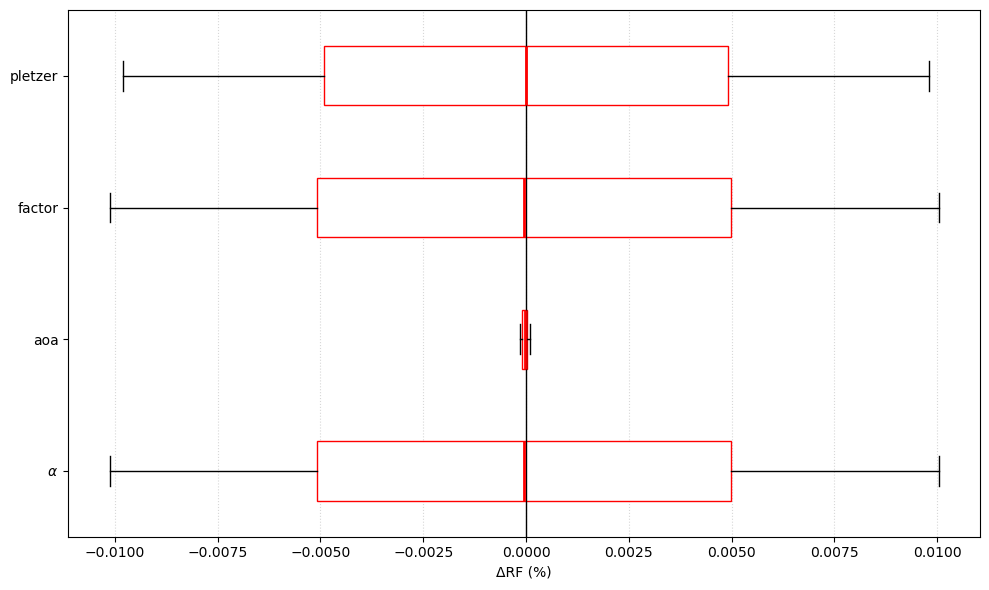

In [46]:
data = [
    sensitivity_dict['alpha'],   # alpha
    sensitivity_dict['aoa'],    # aoa
    sensitivity_dict['factor'],    # factor
    sensitivity_dict['pletzer'],    # pletzer
]

labels = [
    r"$\alpha$",
    r"aoa",
    r"factor",
    r"pletzer",
]

# -----------------------------
# PLOT
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal boxplots
bp = ax.boxplot(
    data,
    vert=False,
    patch_artist=True,
    showfliers=False,
    # whiskerprops=dict(visible=False),
    # capprops=dict(visible=False),
    tick_labels=labels,
    boxprops=dict(facecolor="white", color="red"),
    medianprops=dict(color="red", linewidth=2),
    # whiskerprops=dict(color="red", linestyle="--"),
    # capprops=dict(color="red"),
    # flierprops=dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none'),
)

# Axis styling
ax.axvline(0, color="black", linewidth=1)  # vertical zero reference
ax.set_xlabel(r"ΔRF (%)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)

# Tidy layout
plt.tight_layout()
plt.show()

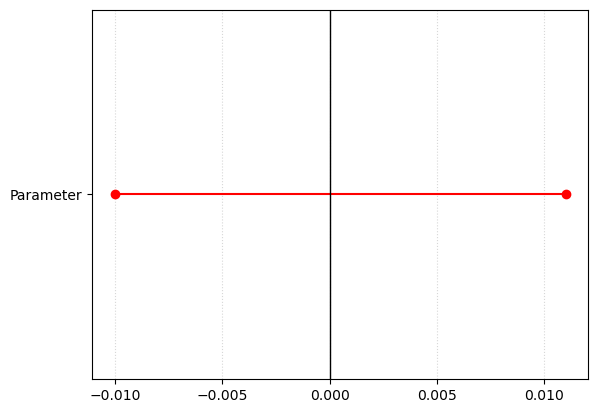

In [47]:
dataqq = [-0.01, 0.011]

plt.plot(dataqq, [1, 1], "o-", color="red")
plt.yticks([1], ["Parameter"])
plt.axvline(0, color="black", linewidth=1)
plt.grid(True, axis="x", linestyle=":", alpha=0.5)
plt.show()

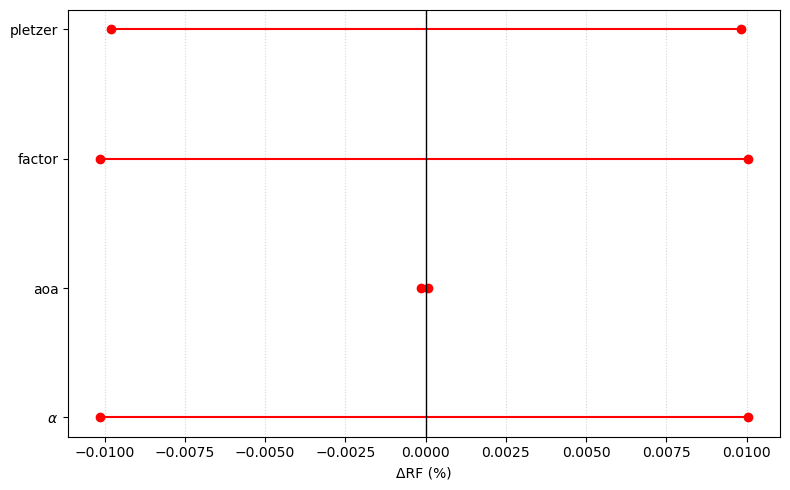

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, values in enumerate(data):
    vmin, vmax = min(values), max(values)
    
    # Horizontal line (range)
    ax.plot([vmin, vmax], [i, i], '-', marker='o', color='red')
    
# Formatting
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel("ΔRF (%)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

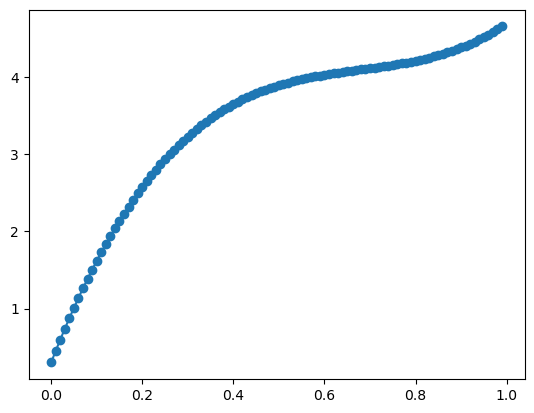

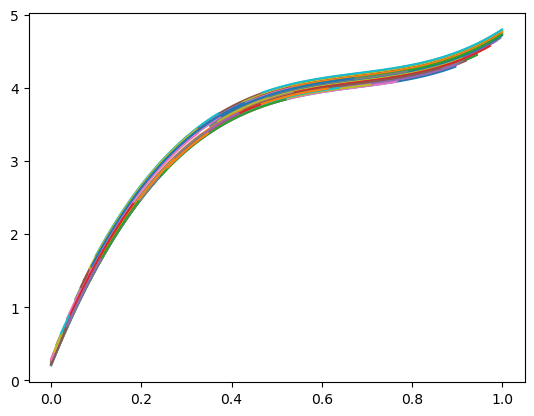

In [49]:
qqq = np.arange(0,1,0.01)
q = 0.3 + 15.2 * qqq - 21.2 * qqq**2 + 10.4 * qqq**3
plt.plot(qqq,q, marker='o')
plt.show()

for i in range(100):
    x = random.uniform(-0.1,0.1)
    qqq = (qqq+x).clip(0,1)
    q = 0.3 + 15.2 * qqq - 21.2 * qqq**2 + 10.4 * qqq**3 + x
    plt.plot(qqq,q)
    
plt.show()

In [ ]:
q


In [ ]:
qqq

In [ ]:
d